# Track recommender system

As in most cases, when interacting with a chatbot, a user has no information registered about his tastes and I have no dataset nor informations about other user tastes, it is more meaning-ful to build a recommender system based on the similarity between a track he likes and other tracks. So I decided to build a content-based collaborative-filtering recommender system called **More like This** (MLT).



In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

In [2]:
tracks=pd.read_csv("datasets/data.csv", sep=',')

In [3]:
tracks.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [4]:
tracks.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

So the dataset I am using is a dataset from spotify containing feature informations about 170000 tracks and can serve as a good dataset to recommend music to users.

<AxesSubplot:>

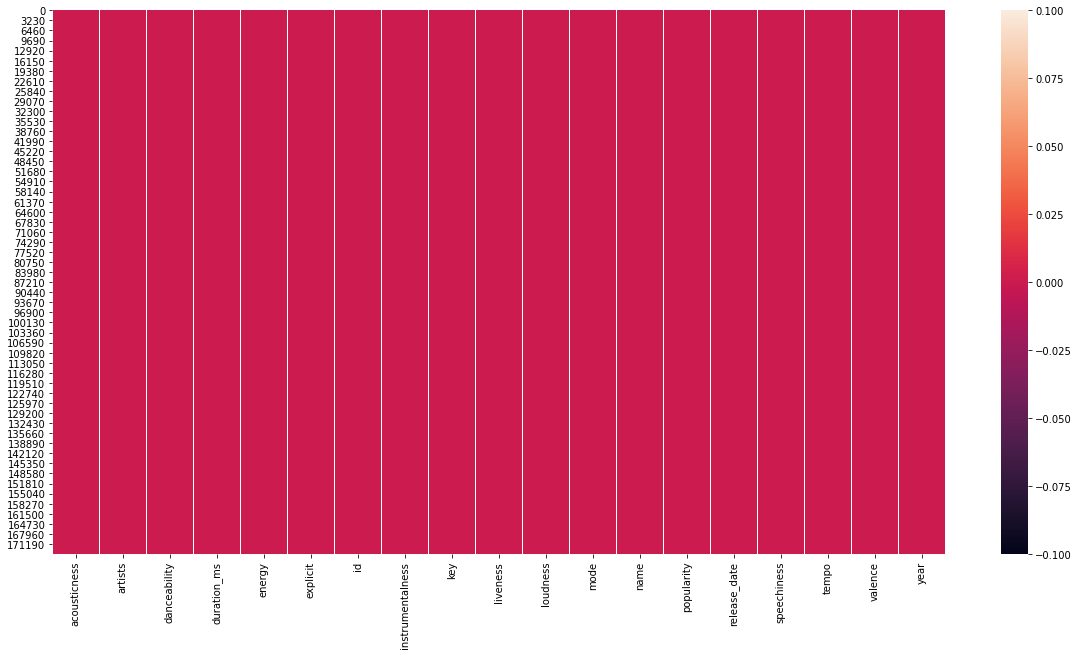

In [5]:
# checking missing values
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(20,10))
sns.heatmap(tracks.isna())



No missing values.

As there are a lot of information that are not interesting for the building of the recommender system, I decided to delete the columns :

- Artists -> to many artists to base a similarity on this parameter
- Name -> as the Id is the same that from the API, this is the only identificator needed
- Year and release_date -> these informations are not in the track features sent by the API

In [6]:
df=tracks.copy()

In [7]:
df=df.drop(['artists', 'name', 'release_date', 'explicit','year', 'popularity', 'duration_ms'], axis=1)

In [8]:
df=df.set_index('id')
df.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
id,,,,,,,,,,,
0cS0A1fUEUd1EW3FcF8AEI,0.991000,0.598,0.224,0.000522,5,0.3790,-12.628,0,0.0936,149.976,0.6340
0hbkKFIJm7Z05H8Zl9w30f,0.643000,0.852,0.517,0.026400,5,0.0809,-7.261,0,0.0534,86.889,0.9500
11m7laMUgmOKqI3oYzuhne,0.993000,0.647,0.186,0.000018,0,0.5190,-12.098,1,0.1740,97.600,0.6890
19Lc5SfJJ5O1oaxY0fpwfh,0.000173,0.730,0.798,0.801000,2,0.1280,-7.311,1,0.0425,127.997,0.0422
2hJjbsLCytGsnAHfdsLejp,0.295000,0.704,0.707,0.000246,10,0.4020,-6.036,0,0.0768,122.076,0.2990


To build a simple MLT system, I just need to compute the similarity between a given track and all the tracks in the database and return the most similars.

To do so I need to implement a similarity function between two tracks, for that I decided to use the cosine similarity.

First, to compute the cosine similarity, I need to normalize the data. In order to do so I will use a mean normalization

In [9]:
#normalized_df=(df-df.mean())/df.std()
normalized_df=(df-df.min())/(df.max()-df.min())

In [10]:
normalized_df.head()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
id,,,,,,,,,,,
0cS0A1fUEUd1EW3FcF8AEI,0.994980,0.605263,0.224,0.000522,0.454545,0.3790,0.741868,0.0,0.096395,0.615900,0.6340
0hbkKFIJm7Z05H8Zl9w30f,0.645582,0.862348,0.517,0.026400,0.454545,0.0809,0.825918,0.0,0.054995,0.356823,0.9500
11m7laMUgmOKqI3oYzuhne,0.996988,0.654858,0.186,0.000018,0.000000,0.5190,0.750168,1.0,0.179197,0.400810,0.6890
19Lc5SfJJ5O1oaxY0fpwfh,0.000174,0.738866,0.798,0.801000,0.181818,0.1280,0.825135,1.0,0.043769,0.525640,0.0422
2hJjbsLCytGsnAHfdsLejp,0.296185,0.712551,0.707,0.000246,0.909091,0.4020,0.845102,0.0,0.079094,0.501324,0.2990


In [11]:
import math
def cosine_similarity(v1,v2):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxx*sumyy != 0:
        return sumxy/math.sqrt(sumxx*sumyy)
    else:
        return 0

In [12]:

track1 = normalized_df.iloc[4,:]
track2 = normalized_df.iloc[22, :]

print(cosine_similarity(list(track1), list(track2)))

0.6065626516117105


Here we can see the data is normalized we can now compute our cosine similarity. To build our recommender system, we will simply 

In [13]:

def get_recommendations(track_vector, track_matrix, N):
    # track vector is the given track vector we want to find similar tracks with
    # N is number of similar tracks returned
    res={}
    # compute the similarity for each track of the dataset
    for trackId, track in track_matrix.iterrows():
        # as we don't want to return the same track 
        res[trackId]=cosine_similarity(list(track_vector), list(track))
    #sort the result
    res=dict(sorted(res.items(), key=lambda res: res[1], reverse=True)[:N])
    return res             



In [14]:
recommendations=get_recommendations(track1, normalized_df, 2)

In [15]:
def displayResults(recommendations):
    for id, score in recommendations.items():
        track=tracks.loc[tracks['id']==id]
        name=track['name'].values[0]
        artists=track['artists'].values
        print('Title : {}, artists : {}, score : {}'.format(name, artists, score))

In [16]:
displayResults(recommendations)

Title : Xuniverxe, artists : ["['Mixe']"], score : 1.0
Title : Harold the Barrel, artists : ["['Genesis']"], score : 0.9975424470398455


By listening to the song, we can see that they are not similar at all, there are a lot of ameliorations to compute with the recommender system. But that was just a test, we didn't even cluster the data. 

As tracks from very different genres can have the same characteristics, it could be interesting to cluster the songs taking in account this feature to add a new feature to our tracks

### Clustering

In [17]:
data=normalized_df.copy()

In [18]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=10)
category=km.fit_predict(normalized_df)
normalized_df['category']=category
normalized_df['category']=(normalized_df['category'] - normalized_df['category'].min())/(normalized_df['category'].max() - normalized_df['category'].min())

In [19]:
# as the normalized categories are in the same order, we store them in a list
# and will use the index+1 (as index begins at 0) to get the corresponding category non-normalized
normalize_categories=list(normalized_df['category'].unique())
normalize_categories.sort()

Seems good, but as the data coming from the API does not have this new feature, we can create a function to calculate a category for a given track

In [20]:
def get_category(track, KM):
    track=pd.DataFrame(track)
    category=KM.predict(track)
    category=normalize_categories[category[0]-1] #getting the normalized cat
    track['category']=category
    return track

In [21]:
track1 = data.iloc[4,:]
track1=pd.DataFrame(track1)

In [22]:
track1=track1.T
print(track1.shape)


(1, 11)


In [23]:

track1=get_category(track1, km)
print(track1)

                        acousticness  danceability  energy  instrumentalness  \
2hJjbsLCytGsnAHfdsLejp      0.296185      0.712551   0.707          0.000246   

                             key  liveness  loudness  mode  speechiness  \
2hJjbsLCytGsnAHfdsLejp  0.909091     0.402  0.845102   0.0     0.079094   

                           tempo  valence  category  
2hJjbsLCytGsnAHfdsLejp  0.501324    0.299  0.333333  


Now that we know how to get the cluster for an unknown vector, we can try to get the recommendations

As the cosine similarity was not really this accurate (similarity close to 1 for songs completely different) I decided to compute the Manhattan Distance that is more focus on each different feature precisely.

In [24]:
def get_recommendations_2(track, tracksDf, N=1):
    #track is a vector of all selected characteristics 
    song=tracks.loc[tracks['id']==track.name]
    print('Getting recommendations for {} by {} '.format(song["name"].values[0], song.artists.values[0]))
    res={}
    res[track.name]=1000
    for trackId, otherTrack in tracksDf.iterrows():
        dist=0
        for col in np.arange(len(tracksDf.columns)):
            # manhattan distance
            dist=dist+np.absolute(float(track[col]) - float(otherTrack[col]))
        res[trackId]=dist
    # sorting by ascending order as we computed distance and not similarity
    res=dict(sorted(res.items(), key=lambda res: res[1])[1:N]) #we do not take the first value that is the same song
    displayResults(res) 

In [25]:
track_test=normalized_df.iloc[13,:]
recommendations=get_recommendations_2(track_test,normalized_df, 5)

Getting recommendations for Schumacher by ['Justrock'] 
Title : Gottlos, artists : ["['Agonoize']"], score : 0.3599554771209725
Title : Praise You - Radio Edit, artists : ["['Fatboy Slim']"], score : 0.38075408010043077
Title : More Human Than Human, artists : ["['White Zombie']"], score : 0.4398903922967523
Title : Bring the Beat Back, artists : ["['Calagad 13']"], score : 0.445493713015948


After listening to the songs, we can see that the results are much better !
Let's try it with a song we know

In [26]:
track_test2= tracks[tracks['name']=='Billie Jean']
track_test2

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
12263,0.0236,['Michael Jackson'],0.920,293827,0.654,0,5ChkMS8OtdzJeqyybCc9R5,0.015800,11,0.0359,-3.051,0,Billie Jean,83,1982-11-30,0.0401,117.046,0.847,1982
12347,0.0173,['Michael Jackson'],0.932,294227,0.457,0,7J1uxwnxfQLu4APicE5Rnj,0.043600,11,0.0414,-9.620,0,Billie Jean,59,1982-11-30,0.0541,117.002,0.884,1982
53348,0.0168,['Michael Jackson'],0.920,294000,0.579,0,6vR5u5b8JeRESx5nZaIWx6,0.053000,11,0.0419,-5.517,0,Billie Jean,54,1995-06-16,0.0414,117.084,0.838,1995
124997,0.8290,['The Civil Wars'],0.532,259920,0.203,0,4zzi2eD2cEPpQ3a307mPPj,0.000000,9,0.1080,-8.524,0,Billie Jean,61,2012,0.0668,89.646,0.543,2012
156041,0.5920,['Chris Cornell'],0.513,281373,0.625,0,7sZD8tOmfRUObogGX8VzfZ,0.000039,4,0.1200,-4.822,0,Billie Jean,46,2007-01-01,0.0436,137.863,0.408,2007


In [27]:
track_test2=normalized_df.iloc[12263,:]

In [28]:
track_test2

acousticness        0.023695
danceability        0.931174
energy              0.654000
instrumentalness    0.015800
key                 1.000000
liveness            0.035900
loudness            0.891849
mode                0.000000
speechiness         0.041298
tempo               0.480668
valence             0.847000
category            0.444444
Name: 5ChkMS8OtdzJeqyybCc9R5, dtype: float64

In [29]:
get_recommendations_2(track_test2,normalized_df, 5)

Getting recommendations for Billie Jean by ['Michael Jackson'] 
Title : Billie Jean, artists : ["['Michael Jackson']"], score : 0.1741409337938068
Title : I Want You, artists : ["['Gary Low']"], score : 0.24962034485312506
Title : Move Ya Body, artists : ["['Nina Sky', 'Jabba']"], score : 0.24993882106425594
Title : Misty Morning - Kaya 40 Mix, artists : ["['Bob Marley & The Wailers', 'Stephen Marley']"], score : 0.27252539621328287


Sound good too

In [30]:
track_test2=normalized_df.loc['5ChkMS8OtdzJeqyybCc9R5',:]

In [31]:
track_test2

acousticness        0.023695
danceability        0.931174
energy              0.654000
instrumentalness    0.015800
key                 1.000000
liveness            0.035900
loudness            0.891849
mode                0.000000
speechiness         0.041298
tempo               0.480668
valence             0.847000
category            0.444444
Name: 5ChkMS8OtdzJeqyybCc9R5, dtype: float64

In [32]:
song = tracks[(tracks['name'].str.lower() == 'Billie Jean'.lower())].head(1)

In [33]:
song['id'].values[0]

'5ChkMS8OtdzJeqyybCc9R5'

In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from math import *

# class to syntethize and integrate the work done on the notebook
class recommender():

    def __init__(self):
        self.tracks=pd.read_csv("datasets/data.csv", sep=',')
        self.normalized_tracks, self.km = self.preprocessing(self.tracks)
        self.normalize_clusters=list(self.normalized_tracks['cluster'].unique()).sort()
    
    
    def euclidean_distance(self, x,y):
         return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
        
    def manhattan_distance(self, x, y):
        return sum(abs(a-b) for a,b in zip(x,y))
    
    def preprocessing(self,df):
        # to gather all the preprocessing steps in one function
        # deleting unwanted features
        df=df.drop(['artists', 'name', 'release_date', 'explicit','year', 'popularity', 'duration_ms'], axis=1)
        df=df.set_index('id')
        #normalize 
        df=(df-df.min())/(df.max()-df.min())
        # clustering
        km=KMeans(n_clusters=10)
        cluster=km.fit_predict(df)
        df['cluster']=cluster
        df['cluster']=(df['cluster'] - df['cluster'].min())/(df['cluster'].max() - df['cluster'].min())
        return df, km

    def get_recommendation(self, track_name, N):
        track = self.tracks[(self.tracks['name'].str.lower() == track_name.lower())].head(1)
        if track is not None:
      # if track found in the dataset getting the vector associated
            track_vector=self.normalized_tracks.loc[track['id'].values[0], :]
            res={}
            for trackId, otherTrack in tqdm(self.normalized_tracks.iterrows()):
                dist=0
                for col in np.arange(len(self.normalized_tracks.columns)):
                # manhattan distance
                    dist=dist+np.absolute(float(track_vector[col]) - float(otherTrack[col]))
                res[trackId]=dist
    # sorting by ascending order as we computed distance and not similarity
            res=dict(sorted(res.items(), key=lambda res: res[1])[1:N]) #we do not take the first value that is the same song
            return res
        else:
              return None
            
            
    def get_recommendation_euclidian(self, track_name, N):
        track = self.tracks[(self.tracks['name'].str.lower() == track_name.lower())].head(1)
        if track is not None:
      # if track found in the dataset getting the vector associated
            track_vector=self.normalized_tracks.loc[track['id'].values[0], :]
            res={}
            for trackId, otherTrack in tqdm(self.normalized_tracks.iterrows()):
                dist=self.euclidean_distance(list(track_vector), list(otherTrack))
                res[trackId]=dist
    # sorting by ascending order as we computed distance and not similarity
            res=dict(sorted(res.items(), key=lambda res: res[1])[1:N]) #we do not take the first value that is the same song
            return res
        else:
              return None
            
    def get_recommendation_manhattan(self, track_name, N):
        track = self.tracks[(self.tracks['name'].str.lower() == track_name.lower())].head(1)
        if track is not None:
      # if track found in the dataset getting the vector associated
            track_vector=self.normalized_tracks.loc[track['id'].values[0], :]
            res={}
            for trackId, otherTrack in tqdm(self.normalized_tracks.iterrows()):
                dist=self.manhattan_distance(list(track_vector), list(otherTrack))
                res[trackId]=dist
    # sorting by ascending order as we computed distance and not similarity
            res=dict(sorted(res.items(), key=lambda res: res[1])[1:N]) #we do not take the first value that is the same song
            return res
        else:
              return None
            
    def displayResults(self, recommendations):
        for id, score in recommendations.items():
            track=tracks.loc[tracks['id']==id]
            name=track['name'].values[0]
            artists=track['artists'].values
            print('Title : {}, artists : {}, score : {}'.format(name, artists, score))
    

  

In [35]:
recom=recommender()

In [36]:
res=recom.get_recommendation_manhattan('Billie Jean', 5)
displayResults(res)

174389it [00:09, 17813.43it/s]


Title : Billie Jean, artists : ["['Michael Jackson']"], score : 0.1741409337938068
Title : I Want You, artists : ["['Gary Low']"], score : 0.24962034485312506
Title : Move Ya Body, artists : ["['Nina Sky', 'Jabba']"], score : 0.24993882106425594
Title : Misty Morning - Kaya 40 Mix, artists : ["['Bob Marley & The Wailers', 'Stephen Marley']"], score : 0.27252539621328287


In [37]:
res=recom.get_recommendation_euclidian('Billie Jean', 3)
displayResults(res)

174389it [00:09, 17811.63it/s]


Title : Billie Jean, artists : ["['Michael Jackson']"], score : 0.09308961526539382
Title : Move Ya Body, artists : ["['Nina Sky', 'Jabba']"], score : 0.10216686580844991


In [38]:
res=recom.get_recommendation_manhattan('I want to break free', 5)
displayResults(res)

174389it [00:09, 19054.41it/s]


Title : I Want To Break Free - Single Version, artists : ["['Queen']"], score : 0.28867632179118335
Title : I Want To Break Free - Remastered 2011, artists : ["['Queen']"], score : 0.30331569199021086
Title : Ghosts, artists : ["['The Jam']"], score : 0.3247442634431798
Title : I Like What You're Doing (To Me), artists : ["['Carla Thomas']"], score : 0.354965536143669


In [39]:
res.keys()

dict_keys(['3ldRLdk3D4cuvrWYmfBQk0', '6NAEpcvbmNdT0cWP3LFDcY', '58NE0639huS0DWQAEKXsB8', '2fnbljRroXC33HuhgyoApM'])

In [42]:
list(res.keys())[1]

'6NAEpcvbmNdT0cWP3LFDcY'